## Detecting and characterising an exoplanet using data from a light-curve

### Data

For this project, we use the data from a light-curve (a series of brightness measurements taken at specific times) of the star WASP-5.

The code for reading the file:

In [4]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("wasp-5b.txt", dtype=float)
t = data[:, 0]
flux = data[:, 1]
flux_error = data[:, 2]

We implement the Box-Least-Squares (BLS) algorithm to find the period of the exoplanet WASP-5b to then determine it's radius and the distance from its sun. The algorithm consists on a phase folding and a binning phase. 

The phase folding shifts the data, so that each period start at the same point. We search through a range of periods to then figure out which is the best-fit period.
The binning phase is used to calculate statistics of the data points that fall inside each bin. These statistics are then used to determine the best-fit period.

In [5]:
#statistics for each data point
weight=1/np.square(flux_error)
f_hat = np.sum(flux*weight)/np.sum(weight)
f_tilde = flux-np.full(np.shape(flux), f_hat)
T=sum(weight)

def bls(trial_period):
        phi_i = np.mod(t-t[0], trial_period) + t[0]

        #binning phase
        #create bins
        expected_duration = 2/24
        bin_edges = np.arange(min(phi_i), max(phi_i), expected_duration)
        distance_from_centre = np.append(np.diff(bin_edges) / 2, (np.diff(bin_edges) / 2)[0])
        bin_centres = distance_from_centre + bin_edges 
        bin_indices=np.digitize(phi_i, bin_edges) 

        #calculate the statistics for data points that fall in each bin 
        S_j=[] 
        R_j=[]

        for j in range(1, len(bin_edges)+1):
            f_i=[] 
            w_i=[] 
            index = np.where(bin_indices==j)[0] 
            
            for i in index:
                f_i.append(f_tilde[i])
                w_i.append(weight[i])
            f_i=np.array(f_i)
            w_i=np.array(w_i)

            S_j.append(np.sum(f_i*w_i))
            R_j.append(np.sum(w_i))

        return np.array(S_j), np.array(R_j), np.array(bin_centres), np.array(phi_i)

def algorithm():
    """function that returns 4 arrays. The trial period, the maximum values of chi_{j}^2 for each trial period, and the depth and epoch associated with each chi """
    P=np.arange(1, 10, 0.01)  
    max_chi = [] 
    max_delta = [] 
    max_t_0 = [] 
    for i in P: 
        denominator = (bls(i)[1] * (T - bls(i)[1]))
        delta_j = bls(i)[0] * T / denominator
        chi_j = np.square(bls(i)[0]) * T / denominator

        index_max_chi = np.where(chi_j == max(chi_j))[0][0]

        max_t_0.append(bls(i)[2][index_max_chi])
        max_chi.append(chi_j[index_max_chi])
        max_delta.append(delta_j[index_max_chi])

    return P, max_chi, max_delta, max_t_0

P, max_chis, delta, t0 = algorithm() 

We have a value of $\Delta \chi ^{2}$ for each trial period. The best-fit trial period will be the one with the maximum value of $\Delta \chi ^{2}$.

Below is a plot of the values of $\Delta \chi ^{2}$ for each trial period P.

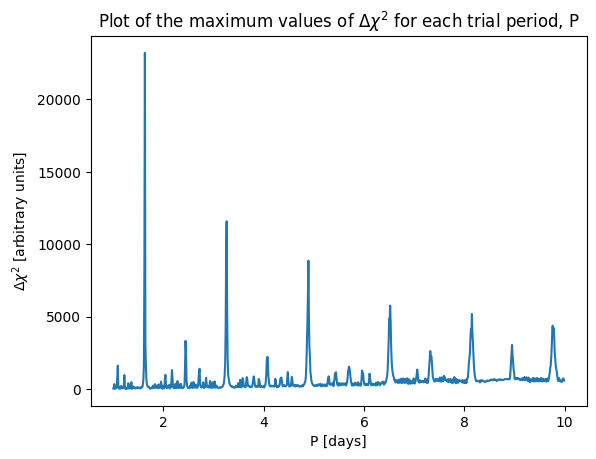

In [6]:
plt.plot(P, max_chis)
plt.title(r"Plot of the maximum values of $\Delta \chi ^{2}$ for each trial period, P")
plt.xlabel("P [days]")
plt.ylabel(r"$\Delta \chi ^{2}$ [arbitrary units]")
plt.show()

In [7]:
index_max_chi = np.where(max_chis == max(max_chis))[0][0]
best_period = P[index_max_chi]
associated_delta = delta[index_max_chi]
associated_t0 = t0[index_max_chi]
phase = bls(best_period)[3]

We now have a best-fit trial period. This is not the real period of the exoplanet though, since we only searched discrete values of the period.

However, the calculated values will be good enough for a first approximation.

To find a better period, we make a basic model of the flux of the star, and fit this model to the actual data.

In [8]:
def F(p, z):
    def l(p, z):
        if 1 + p < z:
            return 0
        
        elif abs(1-p) < z <= 1+p:
            kappa_0 = np.acos(((p**2 + z**2 - 1) / (2 * p * z)))
            kappa_1 = np.acos(((1 - p**2 + z**2) / (2 * z)))
            sqrt = np.sqrt((4*z**2 - (1 + z**2 - p**2)**2) / 4)
            return (1/np.pi) * (p**2 * kappa_0 + kappa_1 - sqrt)
        
        elif z <= 1-p: 
            return p**2
        
        elif z<=p-1:
            return 1
        
    return 1 - l(p, z)


def model_lightcurve(time_stamps, orbital_period, epoch, orbital_separation, size_ratio):
    theta_i = 2*np.pi*(time_stamps - epoch) / orbital_period
    z = abs(orbital_separation * np.sin(theta_i))

    f=[]
    for i in z:
        f.append(F(size_ratio, i))

    
    ind = np.where(np.cos(theta_i)<0)[0]
    for i in ind:
        f[i]=1 

    return f

a_0 = 5
p = np.sqrt(abs(associated_delta))

#fit the model curve to the light curve
from scipy.optimize import curve_fit
params, _ = curve_fit(model_lightcurve, t, flux, p0=(best_period, associated_t0, a_0, p))

#refined parameters
refined_period, refined_t0, refined_a0, refined_p = params
refined_phase = bls(refined_period)[3]

#model flux with refined parameters
f = model_lightcurve(refined_phase, refined_period, refined_t0, refined_a0, refined_p)

The modelled and fitted flux will look like this:

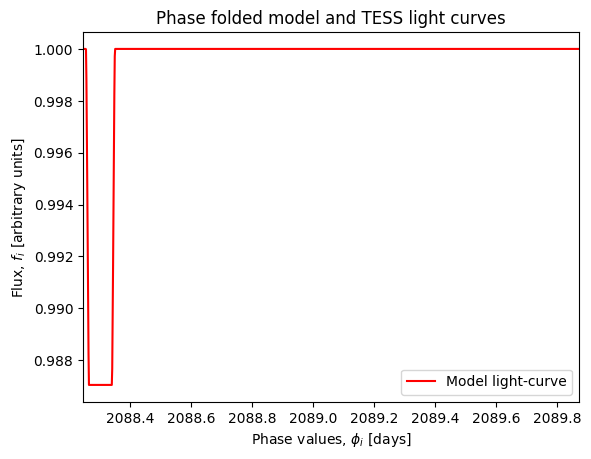

In [13]:
plt.title("Phase folded model and TESS light curves")
plt.plot(t, f, color="r", label="Model light-curve")
plt.xlabel(r"Phase values, $\phi _{i}$ [days]")
plt.ylabel("Flux, $f_{i}$ [arbitrary units]")
plt.xlim(refined_phase[0], max(refined_phase))
plt.legend()
plt.show()

Finally, by knowing some proportions about this system and our Solar System, we can calculate the radius and the radius of the orbit of the exoplanet.

In [12]:
R_jup = 1
R_sun = R_jup / 0.102763
R_star = 1.08 * R_sun
R_p = refined_p * R_star

R_sun_AU = 1/215.032
R_star_AU = 1.08 * R_sun_AU
d = refined_a0 * R_star_AU 

print(f"Refined best-fit period: {refined_period} days")
print(f"Radius of WASP-5b: {R_p} R_jup")
print(f"Radius of the orbit of WASP-5b: {d} AU")

Refined best-fit period: 1.6284328126894285 days
Radius of WASP-5b: 1.1959622145259516 R_jup
Radius of the orbit of WASP-5b: 0.030668877008370343 AU
